In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap.umap_ as umap           # note that umap is not umap in pip, it's umap-learn
import plotly.express as px
from sklearn.manifold import TSNE
import time
import kaleido

In [59]:
#Loading all the data files
data3 = pd.read_csv('../data/kmers/kmer_3.csv')
data5 = pd.read_csv('../data/kmers/kmer_5.csv')
data7 = pd.read_csv('../data/kmers/kmer_7.csv')

data3

,Unnamed: 0,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,...,country_exposure,division_exposure,length,age,sex,pangolin_lineage,year,month,day,variant
0,hCoV-19/Philippines/PH-PGC-03838/2021,920.0,613,580.0,757.0,806.0,372.0,165.0,671.0,600.0,...,Philippines,National Capital Region,29854,47,Male,B.1.1.7,2021,1,22,Alpha
1,hCoV-19/Philippines/PH-PGC-11032/2021,891.0,616,579.0,759.0,808.0,375.0,165.0,672.0,602.0,...,Philippines,National Capital Region,29831,36,Female,B.1.1.7,2021,3,5,Alpha
2,hCoV-19/Philippines/PH-PGC-52854/2021,921.0,614,579.0,759.0,806.0,370.0,164.0,675.0,603.0,...,Philippines,National Capital Region,29851,29,Male,B.1.1.7,2021,6,6,Alpha
3,hCoV-19/Philippines/PH-PGC-47467/2021,922.0,616,579.0,759.0,809.0,375.0,165.0,671.0,601.0,...,Philippines,Northern Mindanao,29878,4,Female,B.1.1.7,2021,5,17,Alpha
4,hCoV-19/Philippines/PH-PGC-59300/2021,765.0,528,500.0,648.0,690.0,318.0,149.0,579.0,515.0,...,Philippines,Ilocos,29806,49,Female,B.1.1.7,2021,7,9,Alpha
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,hCoV-19/Philippines/PGCV_0039_3993/2022,924.0,612,578.0,761.0,801.0,373.0,163.0,669.0,604.0,...,Philippines,Western Visayas,29841,28,Male,XBB.9,2022,10,17,Omicron Sub
491,hCoV-19/Philippines/PGCV_0039_3964/2022,924.0,613,578.0,761.0,803.0,373.0,163.0,670.0,604.0,...,Philippines,Western Visayas,29841,67,Male,XBB.9,2022,10,6,Omicron Sub
492,hCoV-19/Philippines/PH-PGC-06816/2021,883.0,609,572.0,754.0,797.0,372.0,165.0,665.0,600.0,...,Philippines,National Capital Region,29816,40,Male,P.1,2021,2,21,Gamma
493,hCoV-19/Philippines/PH-PGC-13327/2021,864.0,568,549.0,722.0,764.0,357.0,153.0,629.0,574.0,...,Philippines,National Capital Region,29856,42,Male,P.1,2021,3,11,Gamma


In [60]:
# Scratch
slice_col = data3.columns.get_loc('strain')
X = data3.iloc[:, 1:slice_col]
target = data3['variant']
list(map(lambda var: var.replace('_', ' ').title(), target.unique()))
sorted(list(target.unique()))

['Alpha', 'Beta', 'Delta', 'Gamma', 'Omicron', 'Omicron Sub']

## Method 1: Principal Component Analysis 

In [61]:
def pca(data,image_name):
    slice_col = data.columns.get_loc('strain')
    X = data.iloc[:, 1:slice_col]
    target = data['variant']
    print(target.tail())
    x = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    PC = pca.fit_transform(x)
    PDF = pd.DataFrame(data = PC,columns = ['Principal Component 1', 'Principal Component 2'])
    FDF = pd.concat([PDF, data['variant']], axis = 1)
    print('Variance of each component:', pca.explained_variance_ratio_)
    fig = plt.figure(figsize = (10,10))
    plt.rcParams['font.size'] = 20
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel("PC 1 ({:.2%} explained variance)".format(pca.explained_variance_ratio_[0]))
    ax.set_ylabel("PC 2 ({:.2%} explained variance)".format(pca.explained_variance_ratio_[1]))
    targets = sorted(list(target.unique()))
    colors = ['r','b','g','m','c','orange']
    for target, color in zip(targets,colors):
        rowsToKeep = FDF['variant'] == target    # ensures that variant rows are mapped to correct data
        ax.scatter(FDF.loc[rowsToKeep, 'Principal Component 1']
               , FDF.loc[rowsToKeep, 'Principal Component 2']
               , c = color
               , s = 40
                )
    ax.legend(targets,loc='best')
    plt.savefig(image_name)

490    Omicron Sub
491    Omicron Sub
492          Gamma
493          Gamma
494          Gamma
Name: variant, dtype: object
Variance of each component: [0.94339715 0.02262287]
490    Omicron Sub
491    Omicron Sub
492          Gamma
493          Gamma
494          Gamma
Name: variant, dtype: object
Variance of each component: [0.58681464 0.07037968]
490    Omicron Sub
491    Omicron Sub
492          Gamma
493          Gamma
494          Gamma
Name: variant, dtype: object
Variance of each component: [0.15840848 0.06084226]


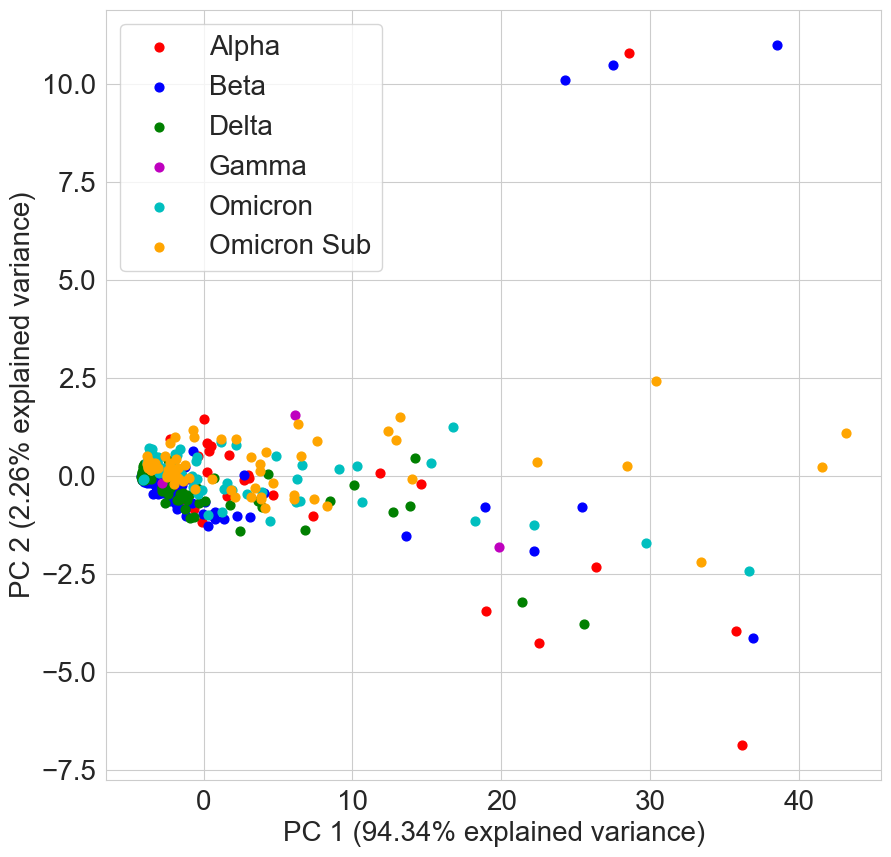

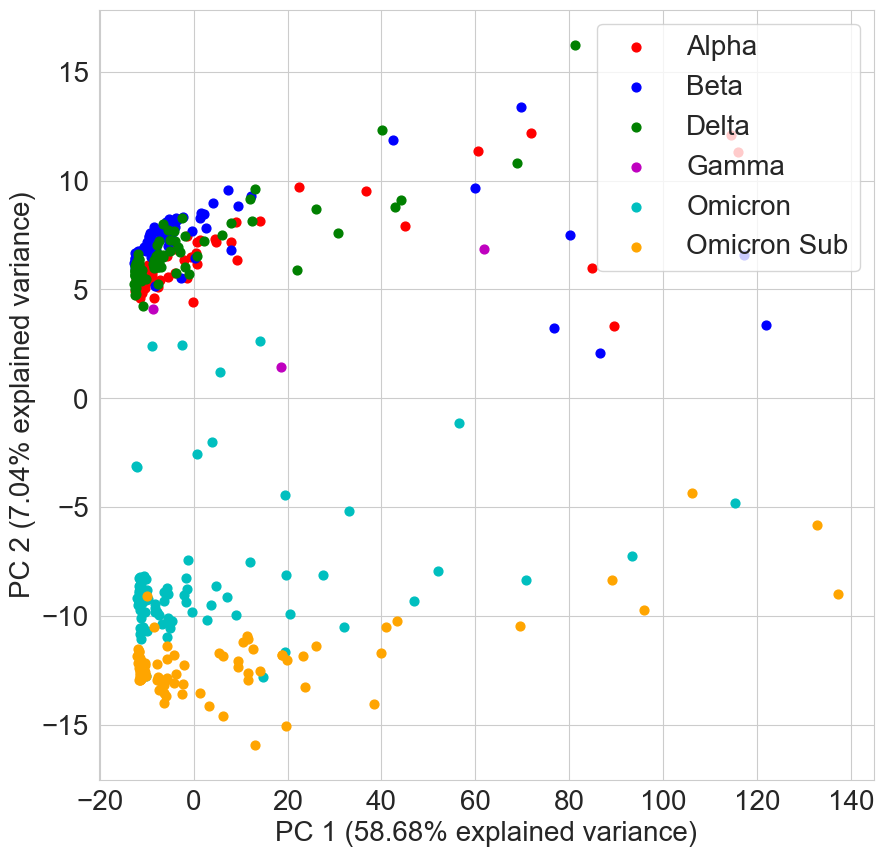

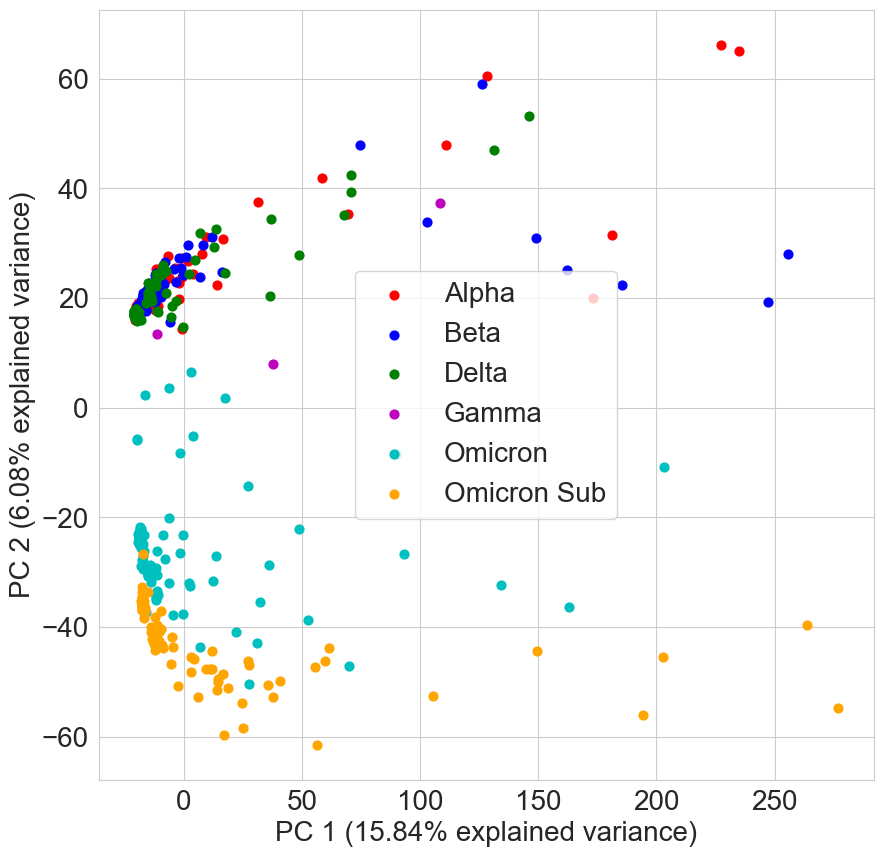

In [62]:
pca(data3,'../results/dim-reduce/pca-3.png')
pca(data5,'../results/dim-reduce/pca-5.png')
pca(data7,'../results/dim-reduce/pca-7.png')

### Combined PCA screenplot

In [63]:
def pcaPlot(data, pt, color, label):
    global fig
    slice_col = data.columns.get_loc('strain')
    X = data.iloc[:, 1:slice_col]
    target = data['variant']
    x = StandardScaler().fit_transform(X)
    pca = PCA(n_components = 10)
    PC = pca.fit_transform(x)
    print('Variance of each component:', pca.explained_variance_ratio_)

    plt.rcParams['font.size'] = 20
    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values, pca.explained_variance_ratio_, pt, linewidth=2, color=color,label=label)
    
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Proportion of Variance Explained')
    plt.legend(loc='best')
    plt.savefig('../results/dim-reduce/pca-combined.png')

Variance of each component: [0.94339715 0.02262287 0.0068363  0.00405764 0.00338494 0.00228067
 0.00177603 0.00176091 0.00145105 0.0011092 ]
Variance of each component: [0.58681464 0.07037968 0.04116455 0.0254254  0.02065622 0.01776829
 0.01525308 0.01168375 0.01152194 0.00936453]
Variance of each component: [0.15840848 0.06084226 0.0525306  0.03672346 0.02605942 0.02467927
 0.02237874 0.02054914 0.01947465 0.01663511]


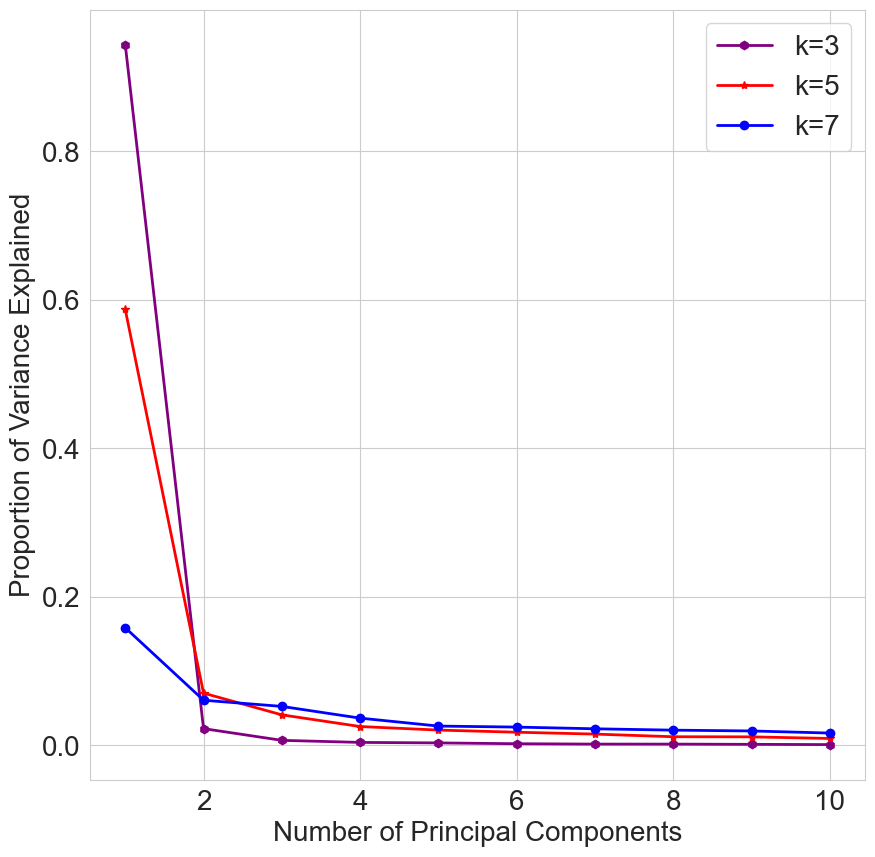

In [64]:
fig = plt.figure(figsize = (10,10))
pcaPlot(data3, 'h-', 'purple', 'k=3')
pcaPlot(data5, '*-', 'red', 'k=5')
pcaPlot(data7, 'o-', 'blue', 'k=7')

## Method 2: t-Distributed Stochastic Neighbor Embedding

In [65]:
def tsne_fn(data, k):
    data = data.sort_values(by='variant', ascending=True)
    slice_col = data.columns.get_loc('strain')
    X = data.iloc[:, 1:slice_col]
    target = data['variant']
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=10)
    tsne_results_1 = tsne.fit_transform(X)
    fig = px.scatter(
    tsne_results_1, x=0, y=1,
    color=target, labels={'color': 'Variant'})
    fig.update_layout(
        xaxis_title="TSNE-2D-1",
        yaxis_title="TSNE-2D-2",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple"))
    fig.update_xaxes(showgrid=False,zeroline=False)
    fig.update_yaxes(showgrid=False,zeroline=False)
    fig.show()

    fig.write_image('../results/dim-reduce/tsne-{}.png'.format(k))
    fig.write_html('../results/dim-reduce/tsne-{}.html'.format(k))

In [66]:
tsne_fn(data3, 3)
tsne_fn(data5, 5)
tsne_fn(data7, 7)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 495 samples in 0.000s...
[t-SNE] Computed neighbors for 495 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 495 / 495
[t-SNE] Mean sigma: 12.834426
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.270802
[t-SNE] KL divergence after 300 iterations: 0.228761


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 495 samples in 0.001s...
[t-SNE] Computed neighbors for 495 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 495 / 495
[t-SNE] Mean sigma: 12.427666
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.280258
[t-SNE] KL divergence after 300 iterations: 0.278216


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 495 samples in 0.053s...
[t-SNE] Computed neighbors for 495 samples in 0.114s...
[t-SNE] Computed conditional probabilities for sample 495 / 495
[t-SNE] Mean sigma: 12.787426
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.259052
[t-SNE] KL divergence after 300 iterations: 0.310385


## Method 3: Uniform Manifold Approximation and Projection (UMAP)

In [67]:
def umap_fn(data, k):
    # Sort data so figure labels are sorted
    data = data.sort_values(by='variant', ascending=True)
    slice_col = data.columns.get_loc('strain')
    X = data.iloc[:, 1:slice_col]
    target = data['variant']
    umap_reduce = umap.UMAP(random_state=10)
    scaled_X = StandardScaler().fit_transform(X)
    emb = umap_reduce.fit_transform(scaled_X)
    emb.shape
    X_o = emb[:,0]
    Y_o = emb[:,1]
    umap_2d = px.scatter(
        emb, x= 0, y= 1,
        color=data.variant, labels={'color': 'Variant'})
    umap_2d.update_layout(
    xaxis_title="UMAP_1",
    yaxis_title="UMAP_2",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"))
    umap_2d.update_xaxes(showgrid=False,zeroline=False)
    umap_2d.update_yaxes(showgrid=False,zeroline=False)
    umap_2d.show()

    umap_2d.write_image('../results/dim-reduce/umap-{}.png'.format(k))
    umap_2d.write_html('../results/dim-reduce/umap-{}.html'.format(k))

In [68]:
umap_fn(data3, 3)
umap_fn(data5, 5)
umap_fn(data7, 7)